This script helps to plot and analyze kaggle titanic sinking data. First I'm adding the required library.



In [1]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns



from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6




/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


I took help for plotting data from [kaggle datascience tutorial](https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial).

In [92]:
class Helper_Plotter():
    def __init__(self):
        """
        This class helps printing various statistics of the data
        """
    def plot_histograms(self, df , variables , n_rows , n_cols ):
        fig = plt.figure( figsize = ( 16 , 12 ) )
        for i, var_name in enumerate( variables ):
            ax=fig.add_subplot( n_rows , n_cols , i+1 )
            df[ var_name ].hist( bins=10 , ax=ax )
            ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
            ax.set_xticklabels( [] , visible=False )
            ax.set_yticklabels( [] , visible=False )
        fig.tight_layout()  # Improves appearance a bit.
        plt.show()

    def plot_distribution(self, df , var , target , **kwargs ):
        row = kwargs.get( 'row' , None )
        col = kwargs.get( 'col' , None )
        facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
        facet.map( sns.kdeplot , var , shade= True )
        facet.set( xlim=( 0 , df[ var ].max() ) )
        facet.add_legend()

    def plot_categories(self, df , cat , target , **kwargs ):
        row = kwargs.get( 'row' , None )
        col = kwargs.get( 'col' , None )
        facet = sns.FacetGrid( df , row = row , col = col )
        facet.map( sns.barplot , cat , target )
        facet.add_legend()

    def plot_correlation_map(self, df ):
        corr = X.corr()
        _ , ax = plt.subplots( figsize =( 12 , 10 ) )
        cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
        _ = sns.heatmap(
            corr, 
            cmap = cmap,
            square=True, 
            cbar_kws={ 'shrink' : .9 }, 
            ax=ax, 
            annot = True, 
            annot_kws = { 'fontsize' : 12 }
        )

    def describe_more(self, df ):
        var = [] ; l = [] ; t = []
        for x in df:
            var.append( x )
            l.append( len( pd.value_counts( df[ x ] ) ) )
            t.append( df[ x ].dtypes )
        levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
        levels.sort_values( by = 'Levels' , inplace = True )
        return levels

    def plot_variable_importance(self, X , y ):
        tree = DecisionTreeClassifier( random_state = 99 )
        tree.fit( X , y )
        self.plot_model_var_imp( tree , X , y )

    def plot_model_var_imp(self, model , X , y ):
        imp = pd.DataFrame( 
            model.feature_importances_  , 
            columns = [ 'Importance' ] , 
            index = X.columns 
        )
        imp = imp.sort_values( [ 'Importance' ] , ascending = True )
        imp[ : 10 ].plot( kind = 'barh' )
        print (model.score( X , y ))    
        


Creating Helper objects and load data and X.head() print the upper 5 rows accordingly.


In [93]:
hlp = Helper_Plotter()

train_df = pd.read_csv("../input/train.csv")
test_df    = pd.read_csv("../input/test.csv")

X = train_df.append( test_df , ignore_index = True )


X.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [94]:
X.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [95]:
hlp.describe_more(X)

,Datatype,Levels,Variable
8,object,2,Sex
10,float64,2,Survived
2,object,3,Embarked
7,int64,3,Pclass
9,int64,7,SibSp
5,int64,8,Parch
0,float64,98,Age
1,object,186,Cabin
3,float64,281,Fare
11,object,929,Ticket


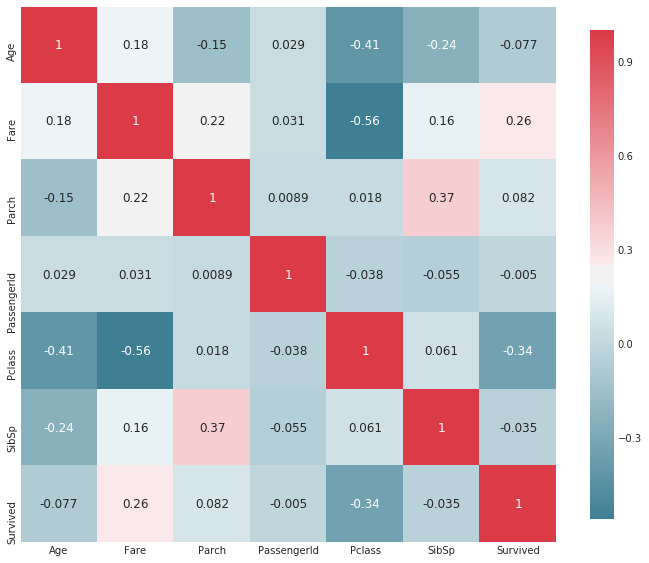

In [96]:
hlp.plot_correlation_map(X)

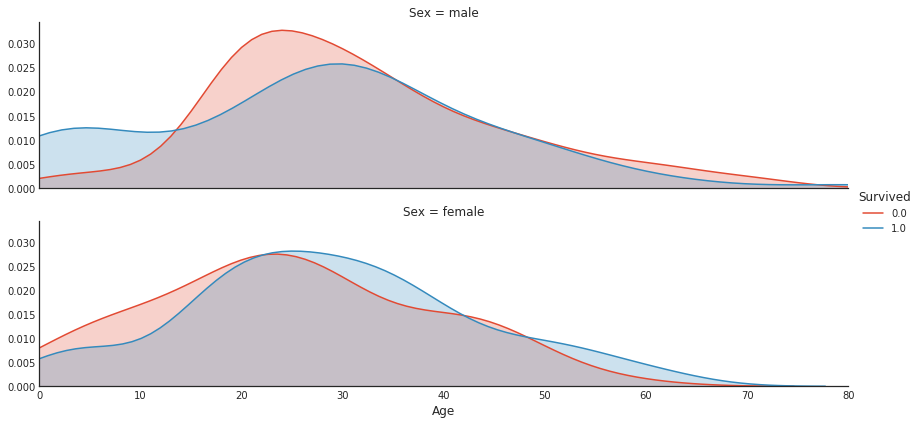

In [64]:
hlp.plot_distribution( X , var = 'Age' , target = 'Survived' , row = 'Sex' )

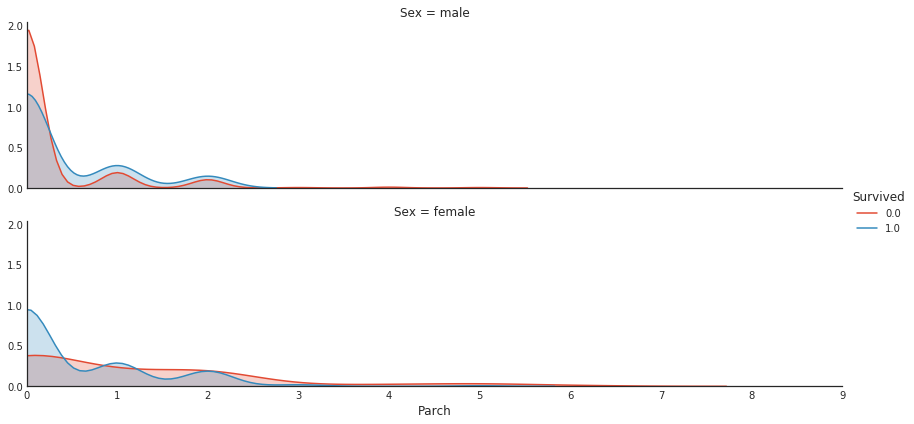

In [65]:
hlp.plot_distribution( X , var = 'Parch' , target = 'Survived' , row = 'Sex' )

In the above graphs we can see the importance of the distribution. If two curve (survived and not survived) are same then this feature won't help distinguish survived person. 

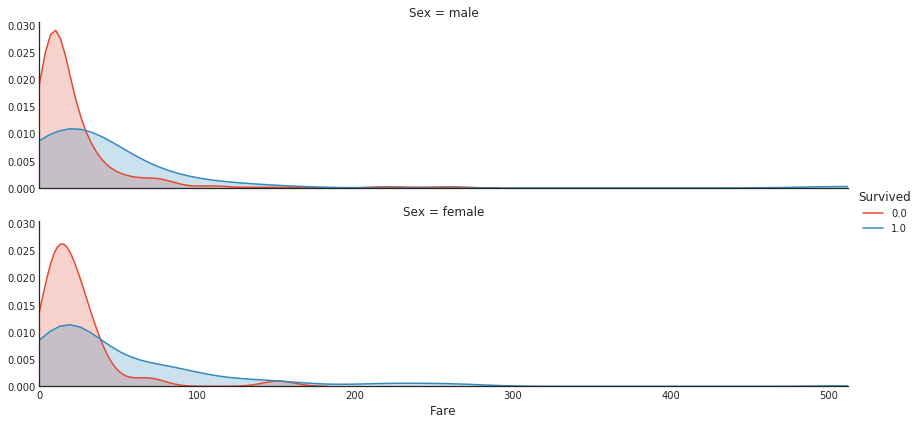

In [66]:
hlp.plot_distribution( X , var = 'Fare' , target = 'Survived' , row = 'Sex' )

From the fare distribution we can see that fare feature is very important because the 
difference is shown in the graph.

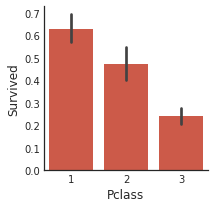

In [67]:
hlp.plot_categories( X , cat = 'Pclass' , target = 'Survived' )

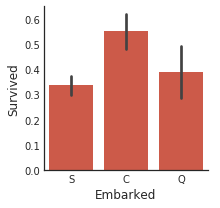

In [68]:
hlp.plot_categories( X , cat = 'Embarked' , target = 'Survived' )

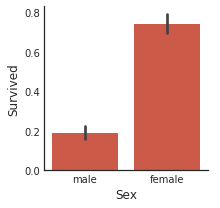

In [69]:
hlp.plot_categories( X , cat = 'Sex' , target = 'Survived' )

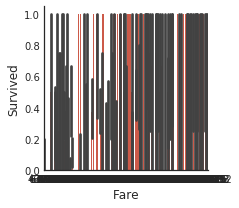

In [70]:
hlp.plot_categories( X , cat = 'Fare' , target = 'Survived' )

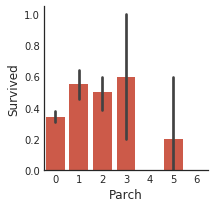

In [22]:
hlp.plot_categories( X , cat = 'Parch' , target = 'Survived' )

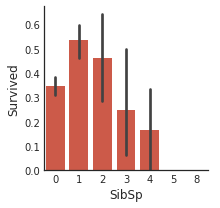

In [71]:
hlp.plot_categories( X , cat = 'SibSp' , target = 'Survived' )

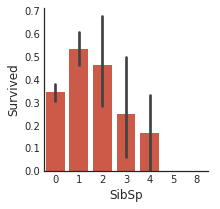

In [72]:
hlp.plot_categories( X , cat = 'SibSp' , target = 'Survived' )

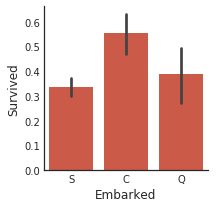

In [73]:
hlp.plot_categories( X , cat = 'Embarked' , target = 'Survived' )

We have three (Embarked, Pclass, Sex) categorical variable in the dataset. Before applying predictive analysis we need to transform it to numerical values. 

In [97]:
# Transform Embarked into numeric
embarked = pd.get_dummies(X.Embarked, prefix='Embarked')
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [98]:
# transform 'Sex' Into numeric
sex = pd.get_dummies(X.Sex,prefix='Sex')
sex.head()
sex = pd.Series(np.where(X.Sex=='male',1,0),name='Sex')
sex.head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

In [76]:
# create a new variable for every unique value of embarked
pclass = pd.get_dummies(X.Pclass, prefix='Pclass')
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


# Filling missing Values
Machine learning algorithm requires to fill the missing values before training it. We use pandas dataframe function fillna() and supply mean to fill the NAN values.


In [99]:
imputed = pd.DataFrame()
imputed['Age'] =  X.Age.fillna(X.Age.mean())
imputed['Fare'] = X.Fare.fillna(X.Fare.mean())
imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [100]:
title = pd.DataFrame()
title['Title'] = X['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())
title.head()

,Title
0,Mr
1,Mrs
2,Miss
3,Mrs
4,Mr


In [101]:
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

In [102]:
title['Title']=title.Title.map(Title_Dictionary)

title=pd.get_dummies(title.Title)
title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [103]:
cabin = pd.DataFrame()
cabin['Cabin'] = X.Cabin.fillna('U')

cabin['Cabin'] = cabin['Cabin'].map(lambda c:c[0])
#encoding
cabin = pd.get_dummies(cabin['Cabin'],prefix='Cabin')
cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


# Extract Ticket class from ticket number


In [104]:
def getCleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t: t.strip(), ticket)
    ticket = list(filter(lambda t: not t.isdigit(), ticket))
    if len(ticket)>0:
        return ticket[0]
    else:
        return 'XXX'
    
    
    
ticket = pd.DataFrame()
    
ticket ['Ticket'] = X.Ticket.map(getCleanTicket)
ticket = pd.get_dummies(ticket['Ticket'],prefix='Ticket')
ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Creating family size using two variable Parch and SibSp


In [105]:
family = pd.DataFrame()
family['FamilySize'] = X['Parch']+X['SibSp']+1 #adding members together

family['Family_Single'] = family['FamilySize'].map(lambda s:1 if s==1 else 0)

family['Family_Small'] = family['FamilySize'].map(lambda s:1 if 2<=s<=4 else 0)
family['Family_Large'] = family['FamilySize'].map(lambda s:1 if 5<=s else 0)
family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [106]:
X_Sel = pd.concat([imputed, embarked, cabin, sex], axis=1)
X_Sel.head()

,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Sex
0,22.0,7.2500,0,0,1,0,0,0,0,0,0,0,0,1,1
1,38.0,71.2833,1,0,0,0,0,1,0,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,0,0,0,0,0,0,0,0,1,0
3,35.0,53.1000,0,0,1,0,0,1,0,0,0,0,0,0,0
4,35.0,8.0500,0,0,1,0,0,0,0,0,0,0,0,1,1


In [107]:
train_valid_X = X_Sel[:train_df.shape[0]]
train_valid_y = X.Survived[:train_df.shape[0]]
train_valid_y.shape
test_X = X_Sel[train_df.shape[0]:]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )


# Feature Selection and Importance
Selecting features from the given set of data. Not all the features are important for modeling the classifier. Some features have import role while others are not significant. 

0.985553772071


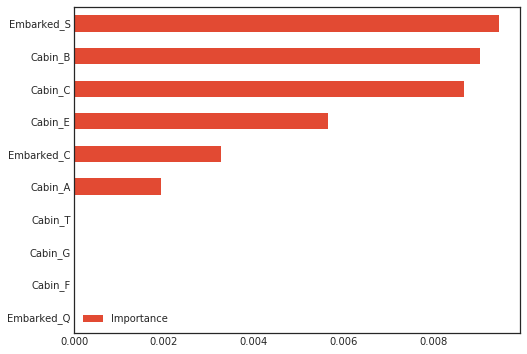

In [108]:
hlp.plot_variable_importance(train_X, train_y)

In [119]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_X,train_y)

sv = SVC()
sv.fit(train_X,train_y)

gb = GradientBoostingClassifier()
gb.fit(train_X,train_y)

kn = KNeighborsClassifier(n_neighbors = 3)
kn.fit(train_X,train_y)

gnb = GaussianNB()
gnb.fit(train_X,train_y)

lr = LogisticRegression()
lr.fit(train_X,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We train various models. Now it is time to evaluate them.

In [122]:
rf.score(train_X,train_y),rf.score(valid_X,valid_y)

(0.985553772070626, 0.78358208955223885)

In [123]:
sv.score(train_X,train_y),sv.score(valid_X,valid_y)

(0.8378812199036918, 0.69402985074626866)

In [124]:
gb.score(train_X,train_y), gb.score(valid_X,valid_y)

(0.8908507223113965, 0.81343283582089554)

In [125]:
gnb.score(train_X,train_y), gnb.score(valid_X,valid_y)

(0.7608346709470305, 0.77238805970149249)

In [126]:
lr.score(train_X,train_y), lr.score(valid_X,valid_y)

(0.7849117174959872, 0.80597014925373134)

# automatic feature selection


In [127]:
rfecv = RFECV( estimator = model , step = 1 , cv = StratifiedKFold( train_y , 2 ) , scoring = 'accuracy' )
rfecv.fit( train_X , train_y )

RFECV(cv=sklearn.cross_validation.StratifiedKFold(labels=[ 1.  0. ...,  0.  1.], n_folds=2, shuffle=False, random_state=None),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

(0.985553772070626, 0.80970149253731338)
Optimal number of features : 5


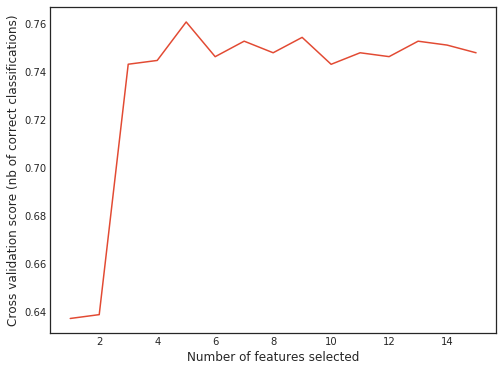

In [130]:
print (rfecv.score( train_X , train_y ) , rfecv.score( valid_X , valid_y ))
print( "Optimal number of features : %d" % rfecv.n_features_ )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel( "Number of features selected" )
plt.ylabel( "Cross validation score (nb of correct classifications)" )
plt.plot( range( 1 , len( rfecv.grid_scores_ ) + 1 ) , rfecv.grid_scores_ )
plt.show()